## Semi-Supervised Machine Learning

In semi-supervised machine learning, a large portion of the dataset is unlabeled. Here, the classifier is trained on the entire dataset to predict the labels of the unlabeled data in the training set. In the present problem, 92% of the data are unlabeled with the 8% been labeled data. 

By using self-training semi-supervised learning method, we will be training the following three classifiers: 
1. Logistic Regression
2. Random Forest
3. XGBoost

Additionally, the ground truth or true labels of the unlabeled dataset is used to validate the performance of the self-training semi-supervised learning models, however in real world scenario the ground truth of the unlabeled dataset will not be given. 

In [5]:
%matplotlib inline

# Ignore deprecated warning
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split

plt.rcParams.update({'font.size': 15})

In [6]:
# Import custom class
%run -i '../src/ss_transfxns.py'
%run -i '../src/ss_ml.py'
%run -i '../src/sup_ml.py'

In [7]:
# Instantiate the class
transfxn = TransformationPipeline()
model = SemiSupervised()

In [9]:
df = pd.read_csv('kdd99-unsupervised-ad.csv', header=None)
print("Data size:", df.shape) # print data size
df.columns = ['v_{}'.format(i) for i in range(30)] 
#df.head() # display the data

Data size: (620098, 30)


In [10]:
# Convert to string
cols = ['v_6', 'v_7', 'v_8', 'v_9']
for i, val in enumerate(cols):
    df[val] = df[val].astype('O')

In [11]:
# Create feature matrix and class label
X, y = df.drop('v_29', axis = 1), df.v_29

#### Create unlabeled dataset

We remove some labels and relabel them as "unknown", denoted by the value -1.

In [12]:
# Map to binary
y_ = y.map({'n':0, 'o':1})

In [13]:
X_u, X_l, y_u, y_l = train_test_split(X,y_, test_size=0.08, stratify=y_, random_state=42)

In [14]:
unlabeled_set = list(X_u.index) # unlabeled indices
y_train = np.copy(y_) # copy labels
y_train[unlabeled_set] = -1 # set unlabeled dataset to -1
y_true = y_[unlabeled_set] # True labels of the unlabeled dataset

In [15]:
print("Original class distribution")
print('-'*25)
label_pct = y_.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_)
label_ct =  y_.map({0:'normal',1: 'attack'}).value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values, 
        'percentage': label_pct.values,
    }
)

Original class distribution
-------------------------


,labels,count,percentage
0,normal,619046,99.830349
1,attack,1052,0.169651


In [16]:
print("Class distribution for semi-supervised learning")
print('-'*45)
label_pct = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})\
                .value_counts(normalize=True)*100
label_ct =  pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'}).value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values,
        'percentage': label_pct.values,
    }
)

Class distribution for semi-supervised learning
---------------------------------------------


,labels,count,percentage
0,unknown,570490,91.999974
1,normal,49524,7.986480
2,attack,84,0.013546


In [17]:
print(" Class distribution for true labels of the unlabeled dataset")
print('-'*45)
label_pct = y_true.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_true)
label_ct =  y_true.value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values,
        'percentage': label_pct.values,
    }
)

 Class distribution for true labels of the unlabeled dataset
---------------------------------------------


,labels,count,percentage
0,normal,569522,99.830321
1,attack,968,0.169679


In [18]:
# Transform and scale data
X_train_scaled, feat_nm = transfxn.preprocessing(X)

In [19]:
print(f'Training set size after pre-processing: {X_train_scaled.shape, y_train.shape}')

Training set size after pre-processing: ((620098, 33), (620098,))


## Self-Training Semi-Supervised Learning

### 1. Logistic Regression

In [20]:
lr_base_classifier = LogisticRegression(random_state = 42)
lr_y_pred, y_proba = model.self_training_clf(
    lr_base_classifier, X_train_scaled, y_train,
    threshold=0.75, max_iter=None,verbose=True
)

print('-' * 40)
print(f"Predicted labels for {len(y_true)} unlabeled data points:")
pd.Series(lr_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570476 new labels.
End of iteration 2, added 11 new labels.
End of iteration 3, added 1 new labels.
----------------------------------------
Predicted labels for 570490 unlabeled data points:


0    569515
1       975
dtype: int64

#### Performance metrics

In [21]:
model.eval_metrics(y_true.values, lr_y_pred[unlabeled_set], 
                        model_nm='Logistic Regression')

Test predictions for Logistic Regression
------------------------------------------------------------
Accuracy:  0.999946
AUROC: 0.993785
AUPRC: 0.968379
Predicted classes: [0 1]
Confusion matrix:
 [[569503     19]
 [    12    956]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569522
           1       0.98      0.99      0.98       968

    accuracy                           1.00    570490
   macro avg       0.99      0.99      0.99    570490
weighted avg       1.00      1.00      1.00    570490

------------------------------------------------------------


#### PCA plot

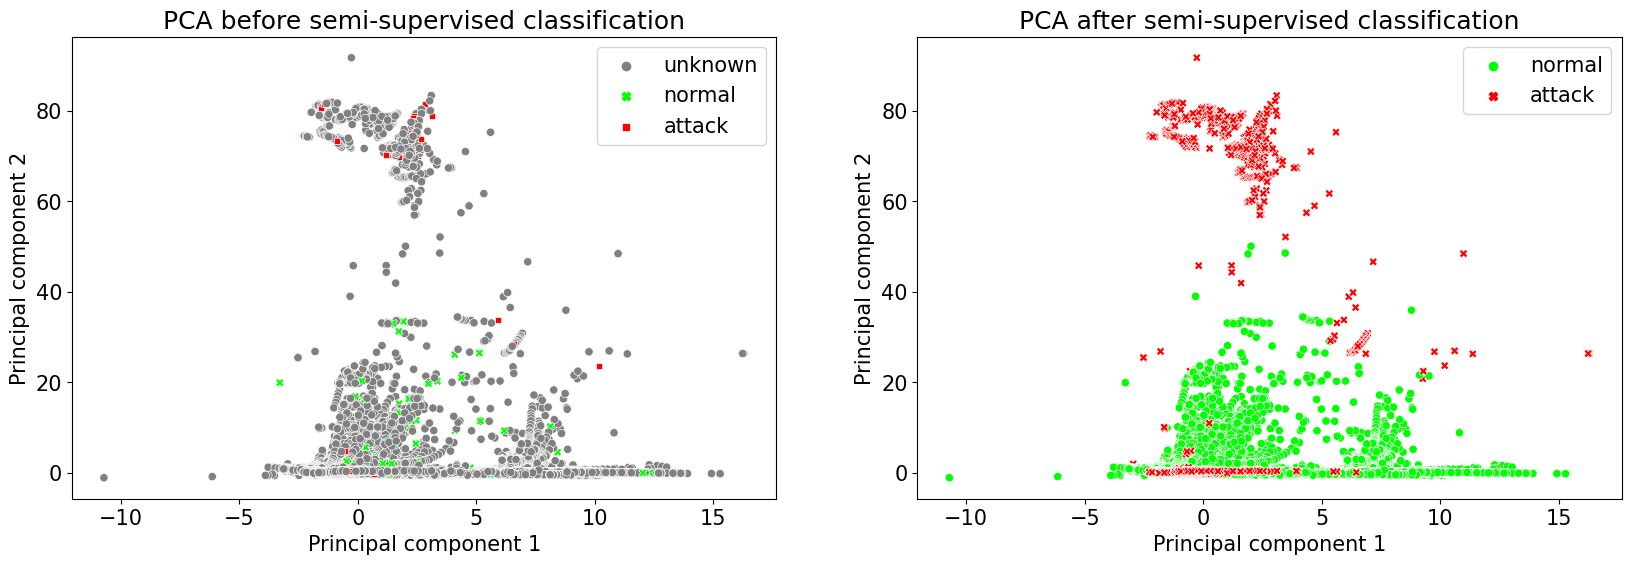

In [22]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
lr_y_pred = pd.Series(lr_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, lr_y_pred)

### 2.  Random Forest 

In [23]:
param_dist = {'n_estimators':100, 'random_state':42}
rf_base_classifier = RandomForestClassifier(**param_dist)
rf_y_pred, y_proba = model.self_training_clf(
    rf_base_classifier, X_train_scaled, y_train,
    threshold=0.75, max_iter=None,verbose=True
)

print('-' * 40)
print(f"Predicted labels for {len(y_true)} unlabeled data points:")
pd.Series(rf_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570406 new labels.
End of iteration 2, added 32 new labels.
End of iteration 3, added 4 new labels.
End of iteration 4, added 4 new labels.
End of iteration 5, added 1 new labels.
End of iteration 6, added 3 new labels.
----------------------------------------
Predicted labels for 570490 unlabeled data points:


0    569549
1       941
dtype: int64

#### Performance metrics

In [24]:
model.eval_metrics(y_true.values, rf_y_pred[unlabeled_set],
                     model_nm='Random Forest Classifier')

Test predictions for Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.999949
AUROC: 0.985536
AUPRC: 0.970092
Predicted classes: [0 1]
Confusion matrix:
 [[569521      1]
 [    28    940]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569522
           1       1.00      0.97      0.98       968

    accuracy                           1.00    570490
   macro avg       1.00      0.99      0.99    570490
weighted avg       1.00      1.00      1.00    570490

------------------------------------------------------------


#### PCA plot

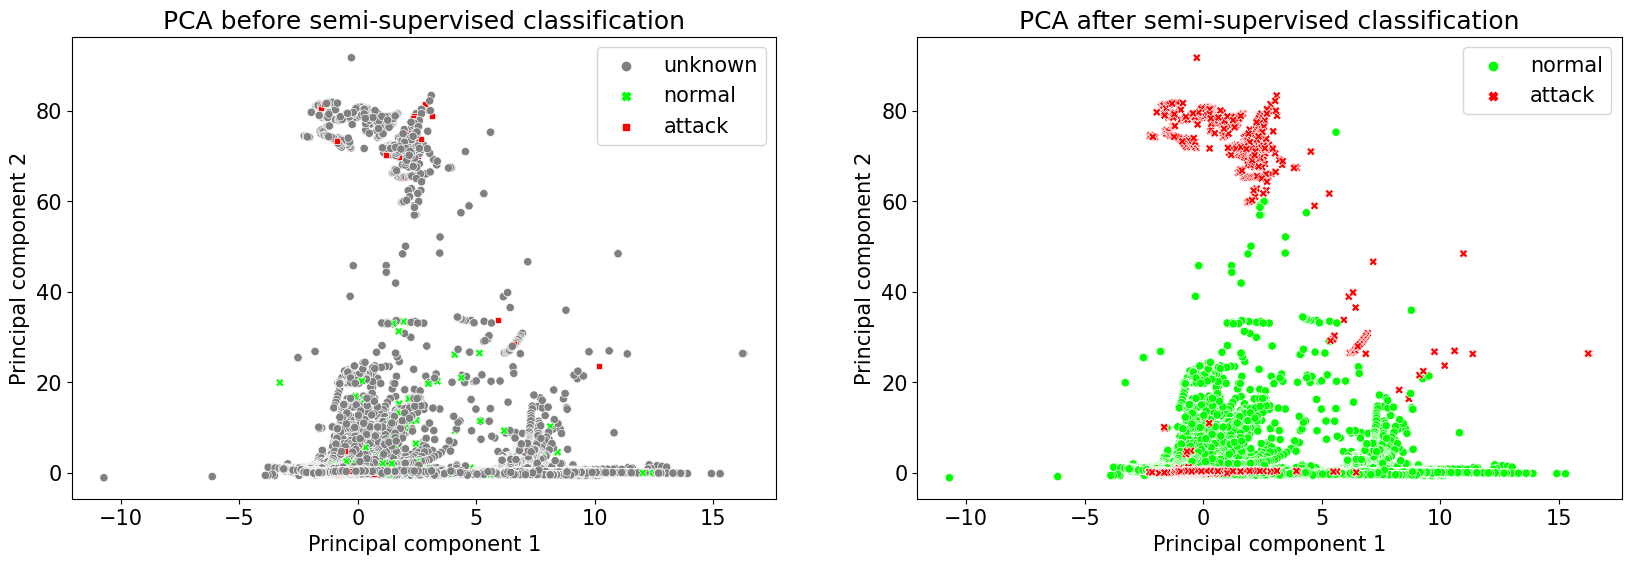

In [25]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
rf_y_pred = pd.Series(rf_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, rf_y_pred)

### 3. XGBoost

In [26]:
param_dist = {'objective':'binary:logistic', 'eval_metric':'logloss', 
              'n_estimators':100, 'learning_rate':0.1, 'random_state':42
            }
                
xgb_base_classifier = XGBClassifier(**param_dist)
xgb_y_pred, y_proba = model.self_training_clf(xgb_base_classifier, X_train_scaled, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)
print('-' * 40)
print(f"Predicted labels for {len(y_true)} unlabeled data points:")
pd.Series(xgb_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 570441 new labels.
End of iteration 2, added 49 new labels.
----------------------------------------
Predicted labels for 570490 unlabeled data points:


0    569523
1       967
dtype: int64

#### Performance metrics

In [27]:
model.eval_metrics(y_true.values, xgb_y_pred[unlabeled_set],
                     model_nm='XGBoost Classifier')

Test predictions for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.999942
AUROC: 0.991205
AUPRC: 0.966212
Predicted classes: [0 1]
Confusion matrix:
 [[569506     16]
 [    17    951]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    569522
           1       0.98      0.98      0.98       968

    accuracy                           1.00    570490
   macro avg       0.99      0.99      0.99    570490
weighted avg       1.00      1.00      1.00    570490

------------------------------------------------------------


#### PCA plot

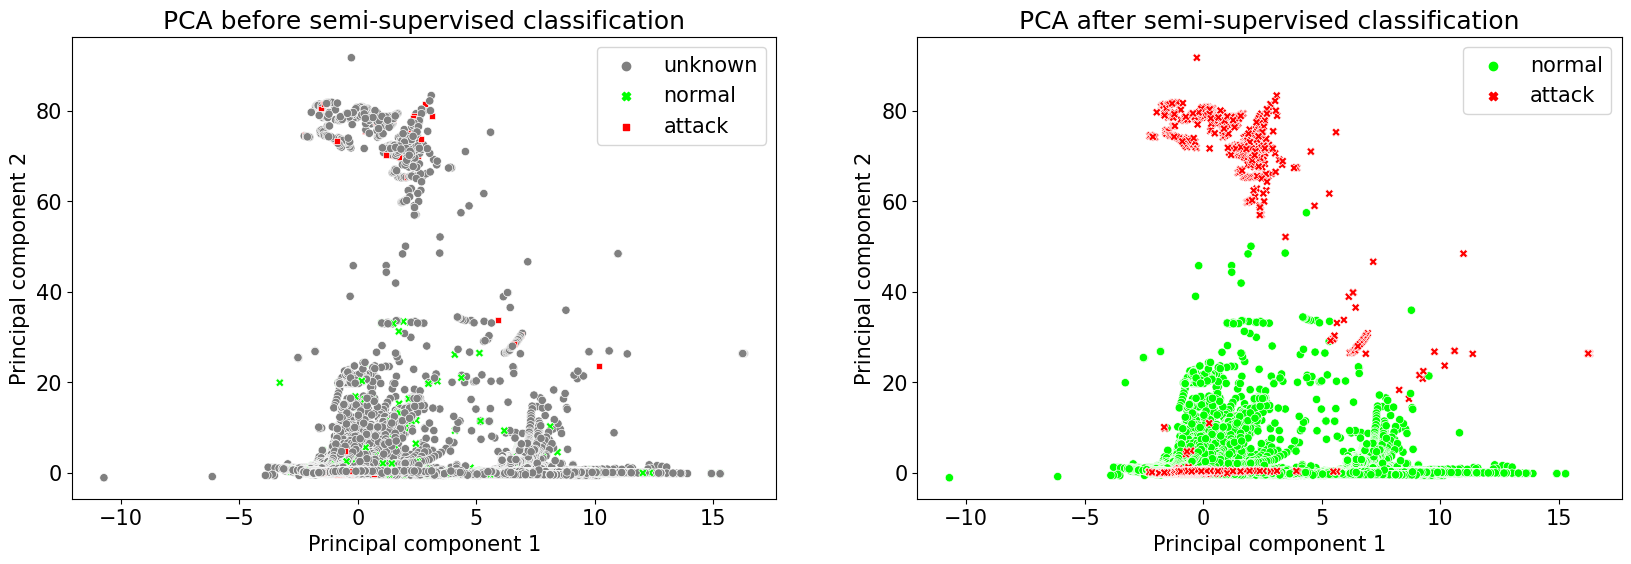

In [28]:
# Re-encode the class variable
y_train_ = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'})
xgb_y_pred = pd.Series(xgb_y_pred).map({0:'normal',1: 'attack'})

transfxn.plot_pca(X_train_scaled, y_train_, xgb_y_pred)